In [ ]:
#Investigation of the Instrument Response Function for three or more images
#Felix Weber
#Nov 25, 2021

#This is an exploratory notebook investigating the reliability of the eigenvector decomposition method of waveform determination currently being used
#Tldr of Results: Fine structure resolution is subject to discrete computational/numerical issues in the eigen vector decomposition method

In [1]:
#Dependancies
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy import constants as const

import os
os.chdir('/Users/felixweber/Physics_Jupyter/PhysicsResearch/ImportantFiles/scintools-master/scintools')
from dynspec import Dynspec
import scipy.constants as sc
import ththmod as THTH

from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences, peak_widths
import scipy.stats as stats
import scipy.optimize as opt

In [2]:
#Compilation of Init Parameters 
#Set conditions

seed = 24
seperation = 0.05 
mean_th = 0 # mean value for theta
sigma_th = 2 # standard deviation of theta
sigma_mu = 1 # for setting magnification

fobs = 800. * u.MHz # Center frequency
delta_f = 40. * u.MHz # Bandwidth
delta_t = 10. * u.hour # Total observing time
num = int(delta_t.value)
nf = 512 # Number of frequency channels
subint_length = 30 * u.s # Length of time per bin
nt = (delta_t.to(u.s)/subint_length).value # Number of time bins

d = 498 * u.pc # Distance to the pulsar
s = 0.62 # Distance to the screen
d_eff = (d*((1-s)/s)).to(u.kpc) # Effective distance
mu_eff = 115.45 * u.mas / u.yr # Proper motion

phasecmap = cm.hsv # set colormap

MiliH = False

In [3]:
##Eigenvector decomposition off of simulated waveforms
#Set currently for Three Images

def Eigmap(seperation, wavef=False, dyns=False, ss=False, th=False, eigm=False):
    
    #Waveform Generation info
    seed = 24
    mean_th = 0 # mean value for theta
    sigma_th = 2 # standard deviation of theta
    sigma_mu = 1 # for setting magnification

    #Dynspec Generation info
    fobs = 800. * u.MHz # Center frequency
    delta_f = 40. * u.MHz # Bandwidth
    delta_t = 10. * u.hour # Total observing time
    num = int(delta_t.value)
    nf = 512 # Number of frequency channels
    subint_length = 20 * u.s # Length of time per bin
    nt = (delta_t.to(u.s)/subint_length).value # Number of time bins

    d = 498 * u.pc # Distance to the pulsar
    s = 0.62 # Distance to the screen
    d_eff = (d*((1-s)/s)).to(u.kpc) # Effective distance
    mu_eff = 115.45 * u.mas / u.yr # Proper motion

    phasecmap = cm.hsv # set colormap

    MiliH = False
    
    theta = np.array((0, seperation, 0.8-seperation)) << u.mas

    # Create magnification for each theta
    magnification = np.exp(-(theta.value**2)/(2*(sigma_mu**2))) # ranges from 0 to 1

    # Create random phase between -pi and pi for each theta
    #np.random.seed(seed)
    phase0 = np.random.random(3) - 0.5 #IMPORTANT Set bracket to # of images
    phase = phase0*2*np.pi
    
    # Creates grids for time and frequency
    f = (fobs + np.linspace(-0.5*delta_f, 0.5*delta_f, nf, endpoint=False) + 0.5*delta_f/nf)
    t = np.linspace(0.*u.minute, delta_t.to(u.minute), int(nt), endpoint=False) + 0.5*delta_t.to(u.minute)/int(nt)

    f, t = np.meshgrid(f, t, sparse=True)

    # Shorthand for plotting the extent of the dynamic spectrum later on
    # Time axis (x) should vary from 0 to delta_t (minutes)
    # Frequency axis (y) should vary from fobs-(delta_f/2) to fobs+(delta_f/2)
    ds_extent = (t[0,0].value  - 0.5*(t[1,0].value - t[0,0].value),
                 t[-1,0].value + 0.5*(t[1,0].value - t[0,0].value),
                 f[0,0].value  - 0.5*(f[0,1].value - f[0,0].value),
                 f[0,-1].value + 0.5*(f[0,1].value - f[0,0].value))

    # Creates a wavefield for each theta - this cell takes the longest to run but should still be less than 10 seconds
    theta_t = theta[:, np.newaxis, np.newaxis] + mu_eff * t
    tau_t = (((d_eff / (2*const.c)) * theta_t**2)
             .to(u.s, equivalencies=u.dimensionless_angles()))

    phasor = np.exp(1j * (f * tau_t * u.cycle).to_value(u.rad))
    dynwaves = phasor * (magnification[:, np.newaxis, np.newaxis])

    # Creates the wavefield by summing the individual wavefields
    dynwave = dynwaves.sum(axis=0) # complex valued

    if wavef == True:
        # Plots the wavefield 
        fig = plt.figure(figsize=(12., 8.))
        ax = plt.subplot(111)
        plt.imshow(np.abs(np.angle(dynwave)).T/np.max(np.abs(dynwave)), 
                   origin='lower', aspect='auto', interpolation='none',
                   cmap=phasecmap, extent=ds_extent)#, vmin=0)#, vmax=)
        plt.title('dynamic wavefield')
        plt.xlabel(rf"time $t$ ({t.unit.to_string('latex')})")
        plt.ylabel(rf"frequency $f$ ({f.unit.to_string('latex')})")
        plt.colorbar()
        plt.show()

    # Create the dynamic spectrum by taking the modulus square of the wavefield
    dynspec = np.abs(dynwave)**2

    if dyns == True:
        # Plot the dynamic spectrum
        plt.figure(figsize=(12., 8.))
        plt.imshow(dynspec.T,
                   origin='lower', aspect='auto', interpolation='none',
                    extent=ds_extent)
        plt.title('Dynamic Spectrum')
        plt.xlabel(rf"Time ({t.unit.to_string('latex')})")
        plt.ylabel(rf"Frequency ({f.unit.to_string('latex')})")

        cbar = plt.colorbar()
        cbar.set_label('Unnormalized Intensity')
        plt.show()
    
    # Create the secondary spectrum
    dynspec_norm = dynspec/dynspec.max() # Normalize the dynamic spectrum

    conspec = np.fft.fft2(dynspec_norm)
    conspec /= conspec[0, 0]
    conspec = np.fft.fftshift(conspec)

    secspec = np.abs(conspec)**2 # Find the modulus square

    # Find Nyquist Frequencies for fd (x) and tau (y)
    tau_nf = (1/(2*(delta_f/nf))).to(u.us)
    fd_nf = (1/(2*subint_length)).to(u.mHz)

    ss_extent = (-fd_nf.value,
                 fd_nf.value,
                 -tau_nf.value, 
                 tau_nf.value)

    if ss == True:
        # Plot the secondary spectrum
        plt.figure(figsize=(12., 8.))
        plt.imshow(secspec.T,
                   origin='lower', aspect='auto', interpolation='none',
                    extent=ss_extent,
                   norm=LogNorm())
        plt.title('Secondary Spectrum')
        plt.xlabel(r"$f_\mathrm{{D}}$ "
                   rf"({fd_nf.unit.to_string('latex')})")
        plt.ylabel(r"$\tau$ "
                   rf"({tau_nf.unit.to_string('latex')})")

        cbar = plt.colorbar()
        cbar.set_label('Unnormalized Power')
        plt.show()
    
    # Get dynamic spectrum ready for th-th transformation 

    dynspec0 = dynspec.T
    
    # Window
    a = np.hamming(dynspec0.shape[0])
    b = np.hamming(dynspec0.shape[1])
    window = np.outer(a,b) 
    dynspec1 = dynspec0*window

    # Pad in time dimension
    dspec_pad = np.pad(dynspec1,((0,0),(0,(8192)-dynspec1.shape[1])),mode='constant',constant_values=dynspec1.mean())

    # Subtract mean
    dspec_pad = dspec_pad - np.mean(dspec_pad)

    # Convert to secondary spectrum
    sspec = np.abs(fftshift(fft2(dspec_pad))) # dtype=Complex

    # th-th transform
    edge = np.linspace(-8,8,1032) 
    time = (t.to(u.s)).value
    freq = (np.linspace(fobs-(delta_f/2),fobs+(delta_f/2),nf)).value
    fd = np.fft.fftshift(np.fft.fftfreq(8192,time[1]-time[0]))*1000*u.mHz 
    tau = np.fft.fftshift(np.fft.fftfreq(nf,freq[1]-freq[0]))*u.us 
    v_eff = mu_eff.to(u.rad/u.s)*d_eff.to(u.m)
    lamda = sc.c/fobs.to(u.Hz)
    eta0 = (d_eff.to(u.m).value*(lamda.value**2))/(2*sc.c*(v_eff.value**2))
    eta = eta0*u.us/u.mHz**2

    thth_red, edges_red = THTH.thth_redmap(sspec, tau, fd, eta.value, edge)

    c = sc.c*u.m/u.s
    sky_coords = ((((((np.sqrt(2*c/d_eff))*(np.sqrt(eta).to(u.s**(1/2)/u.mHz))).to(u.s))*((edges_red[1:]+edges_red[:-1])/2*u.mHz)).to(u.Hz*u.s))*u.rad).to(u.mas)
    #if thth_red.shape[0]<len(edge)-1:
        #print("Fix edge array.")

    if th == True:
        # Plot the th-th diagram
        plt.figure(figsize=(8,8))

        if (MiliH == True):
            # In mHz
            plt.imshow(np.abs(thth_red),norm=LogNorm(), origin='lower', extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],vmin=1,vmax=1e4)
            plt.xlabel(r'$\theta_1$'+"  (mHz)")
            plt.ylabel(r'$\theta_2$'+"  (mHz)")
        else:
            #In mas
            plt.imshow(np.abs(thth_red),norm=LogNorm(), origin='lower', extent=[sky_coords[0].value,sky_coords[-1].value,sky_coords[0].value,sky_coords[-1].value],vmin=1,vmax=1e4)
            plt.xlabel(r'$\theta_1$'+"  (mas)")
            plt.ylabel(r'$\theta_2$'+"  (mas)")

        plt.colorbar(shrink=0.8)
        plt.title(r'$\theta-\theta$'+" Diagram")
        plt.grid()
        plt.show()

    # calculate brightness distribution using eigenvector approach
    eig0, a0 = eigsh(thth_red, 1) # eig is the eigenvalue, a is e-vector
    a_len = int(np.round(len(a0)/2))
    max_og = np.abs(a0[(a_len-20):(a_len+20)]).max() # Naming a separate variable in case I want to reference it later
    I0 = np.abs(a0/max_og)
    I0 = I0**2

    if eigm == True:
        # Graph eigenvector brightness plot
        plt.figure(figsize=(8,4))
        plt.plot(sky_coords,I0,color='black',label="eigenvector")
        plt.scatter(theta,magnification,color='r',label="Input")
        plt.ylabel("Normalized Intensity")
        plt.xlabel('Sky Coordinate (mas)')
        plt.title("Full Observation Input and Output Brightness")
        plt.ylim(-0.1,1.2)
        #plt.xlim(-0.5,0.5)
        plt.legend()
        plt.show()
    
    return I0, sky_coords.value

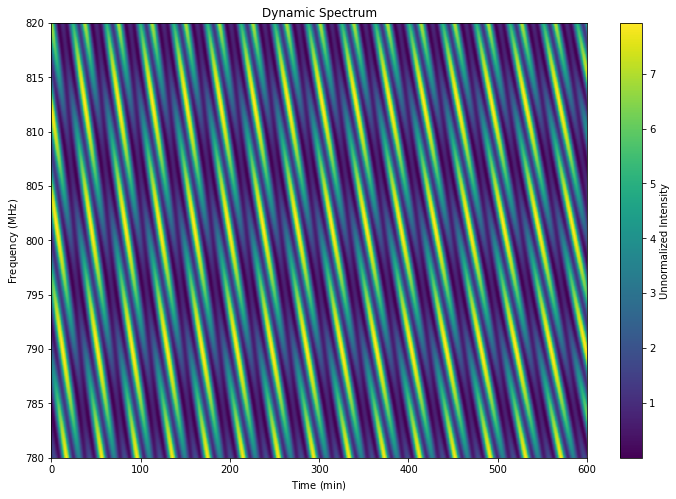

(array([[7.19129615e-12],
        [7.49479908e-12],
        [7.55621095e-12],
        ...,
        [8.43449244e-12],
        [8.31523876e-12],
        [7.94332957e-12]]),
 array([-3.6981776 , -3.69099667, -3.68381574, ...,  3.68381574,
         3.69099667,  3.6981776 ]))

In [4]:
Eigmap(seperation=0.2, dyns=True)

In [5]:
#Map of Eigmap Generation – This cell will take the longest to run ~1 min
#This will generate a series of Eigmaps with waveforms at different image seperation

n = 200
seperation = 0.005
start = -0.1

thetas = np.linspace(start=start,stop=(start+(n)*seperation), num=n, endpoint=False)
I_samp, c_samp = Eigmap(seperation=thetas[0])
I=np.zeros((n, 1031,1))
c=np.zeros((n, 1031))

for i in range(n):
    I[i], c[i] = Eigmap(seperation=thetas[i])

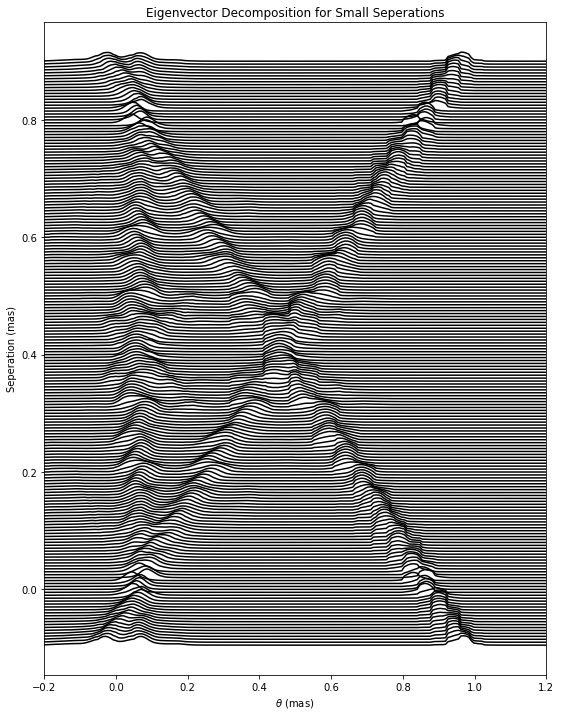

In [6]:
#Map of Eigmap
plt.figure(figsize=(9,12))
plt.title('Eigenvector Decomposition for Small Seperations')
for i in range(n):
    plt.plot(c[i],3*I[i]*seperation+(i+1)*seperation+start,c='black')
plt.xlim(-0.2,1.2)
plt.ylabel('Seperation (mas)')
plt.xlabel(r'$\theta$'+' (mas)')
plt.show()

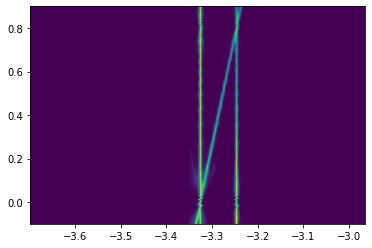

In [16]:
#Colormap of Eigmap
c_map = np.ndarray.flatten(I[0])

for i in range(n-1):
    I0 = np.reshape(I[i+1], (1,1031))
    c_map = np.append(c_map, I0[0])

c_map = np.reshape(c_map, (n,1031))

plt.imshow(np.flip(c_map, axis=0), aspect='auto', extent=[c[0,0],c[0,102],start,start+n*seperation])

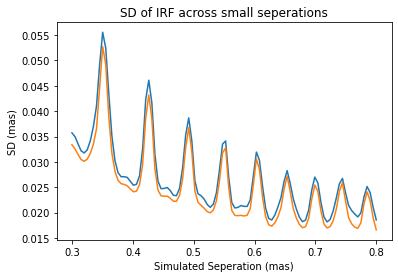

In [10]:
##SD of sample

#Chi-sqaured of double gauss fit
def chi_fit(x0,i):
    fit = x0[4]*np.exp(-0.5*((c-x0[2])**2)/x0[0]**2) + x0[5]*np.exp(-0.5*((c-x0[3])**2)/x0[1]**2)
    fit = fit+1
    i = i+1
    a = ((i.T-fit)**2)/fit
    b = a[0]
    chi = np.sum(b[pnts])
    return chi

A = np.zeros((n,6))

#Initial Guesses – not too important
sig1 = 0.025
sig2 = 0.025
mean1 = 0.055
a1=1
a2=1

B = np.linspace(start,start+n*seperation,n) #Seperation Bins
pnts=(c[0]>-0.1)*(c[0]<1.2) ##Window of fit (smaller the quicker)

for k in range(n):
    i = I[k]
    m2_min = B[k]-0.25
    m2_max = B[k]+0.25
    mean2 = B[k]
    D = opt.minimize(chi_fit, (sig1,sig2,mean1,mean2,a1,a2), args=(i), method="Powell", bounds=((0,0.2),(0,0.2),(-0.1,0.2),(m2_min,m2_max),(0,2),(0,2)))
    A[k] = D.x
    
plt.figure()
plt.title('SD of IRF across small seperations')
plt.ylabel('SD (mas)')
plt.xlabel('Simulated Seperation (mas)')
plt.plot(B,np.abs(A[:,0]))
plt.plot(B,np.abs(A[:,1]))

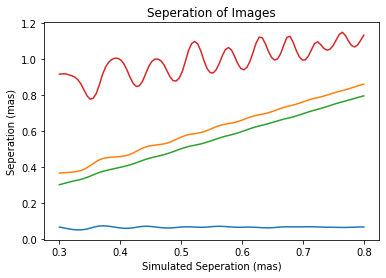

In [134]:
#Seperation Values
B = np.linspace(start,start+n*seperation,n)
plt.figure()
plt.title('Seperation of Images')
plt.ylabel('Seperation (mas)')
plt.xlabel('Simulated Seperation (mas)')
plt.plot(B,np.abs(A[:,2]))
plt.plot(B,np.abs(A[:,3]))
plt.plot(B,np.abs(A[:,3])-np.abs(A[:,2]))
plt.plot(B,A[:,5]/A[:,4])

0.053159080294926934


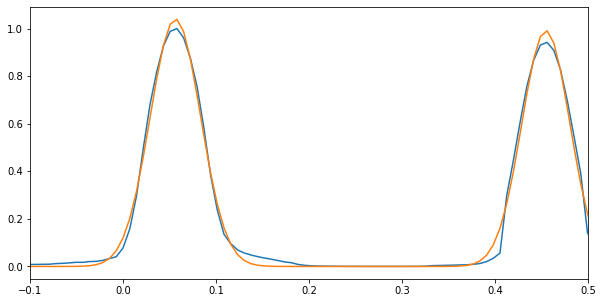

In [3]:
#Singular Eigmap generation & Manual Analysis
I, c = Eigmap(seperation=0.4, eigm=False)
#x0=(0.025,0.025,0.055,0.455,1,1)
x0=(0.02709107, 0.02585722, 0.05629939, 0.45463368, 1.04059612, 0.99195466)

fit = x0[4]*np.exp(-0.5*((c-x0[2])**2)/x0[0]**2) + x0[5]*np.exp(-0.5*((c-x0[3])**2)/x0[1]**2)

pnts=(c>-0.1)*(c<0.5)

plt.figure(figsize = (10,5))
plt.plot(c,I)
plt.plot(c,fit)
plt.xlim(-0.1,0.5)

In [4]:
#Chi-Squared test – Optimization of two normalized gaussians for a single observation
sig1 = 0.025
sig2 = 0.025
mean1 = 0.055
mean2 = 0.455
a1=1
a2=1
scale=16

pnts=(c>-0.1)*(c<0.5)

def chi_fit(x0):
    fit = x0[4]*np.exp(-0.5*((c-x0[2])**2)/x0[0]**2) + x0[5]*np.exp(-0.5*((c-x0[3])**2)/x0[1]**2)
    fit = fit+1
    i = I+1
    a = ((i.T-fit)**2)/fit
    b = a[0]
    chi = np.sum(b[pnts])
    return chi

a = opt.minimize(chi_fit, (sig1,sig2,mean1,mean2,a1,a2), method="Powell", bounds=((0,0.1),(0,0.1),(0,0.1),(0.4,0.5),(0,2),(0,2)))

print("sig1 = " +str(a.x[0]) + "   sig2 = " +str(a.x[1]))
print("mean1 = " +str(a.x[2])+ "   mean2 = " +str(a.x[3]))
print("a1 = " +str(a.x[4])+ "       a2 = " + str(a.x[5]))
print("x => " +str(a.x))

sig1 = 0.02709106921979398   sig2 = 0.025857215409072456
mean1 = 0.056299393843833874   mean2 = 0.4546336794807778
a1 = 1.0405961208593517       a2 = 0.9919546574340139
x => [0.02709107 0.02585722 0.05629939 0.45463368 1.04059612 0.99195466]
